# Include Toolbox

In [1]:
using Plots
import EzXML
import XMLDict

In [2]:
include("ToolBox.jl")
using .ToolBox

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [3]:
Geometry.satellite_trajectory

satellite_trajectory (generic function with 1 method)

### Define test data

In [4]:
path_img1 = "/Users/eyu/YOEO_local/data/S1B_IW_SLC__1SDV_20170315T053950_20170315T054018_004715_0083B0_7EE9.SAFE/measurement/s1b-iw3-slc-vv-20170315t053950-20170315t054018-004715-0083b0-006.tiff"
path_meta_1 = "/Users/eyu/YOEO_local/data/S1B_IW_SLC__1SDV_20170315T053950_20170315T054018_004715_0083B0_7EE9.SAFE/annotation/s1b-iw3-slc-vv-20170315t053950-20170315t054018-004715-0083b0-006.xml"
path_pod_1 = "/Users/eyu/YOEO_local/data/S1B_OPER_AUX_POEORB_OPOD_20170404T111500_V20170314T225942_20170316T005942.EOF";

In [5]:
reflector_height = [42.753,43.282,44.475]
reflector_index_img1 = [[1126,6087],[1123, 6100],[1127, 6111]]
line_sample = vcat(reflector_index_img1'...)

3×2 Array{Int64,2}:
 1126  6087
 1123  6100
 1127  6111

## Load library

In [29]:
#data = Load.slc_data(path_img1, view)
meta = Load.slc_meta(path_meta_1);
precise_orbit = Load.precise_orbit(path_pod_1, meta["t_0"]);

In [30]:
## open xml files
doc = EzXML.readxml(path_meta_1)
meta_dict = XMLDict.xml_dict(doc);

### variables from annotations

In [31]:
k_psi = parse(Float64, meta_dict["product"]["generalAnnotation"]["productInformation"]["azimuthSteeringRate"])
f_etac = meta_dict["product"]["dopplerCentroid"]["dcEstimateList"]["dcEstimate"][1]["dataDcPolynomial"]
k_a = meta_dict["product"]["generalAnnotation"]["azimuthFmRateList"]["azimuthFmRate"][1]["azimuthFmRatePolynomial"]
f_c = parse(Float64, meta_dict["product"]["generalAnnotation"]["productInformation"]["radarFrequency"])
v_s = meta_dict["product"]["generalAnnotation"]["orbitList"]["orbit"][1]["velocity"]
N_l = parse(Int, meta_dict["product"]["swathTiming"]["linesPerBurst"])
Delta_t_s = parse(Float64, meta_dict["product"]["imageAnnotation"]["imageInformation"]["azimuthTimeInterval"])
N_s = parse(Int, meta_dict["product"]["imageAnnotation"]["imageInformation"]["numberOfSamples"])
Delta_tau_s = 1/parse(Float64, meta_dict["product"]["generalAnnotation"]["productInformation"]["rangeSamplingRate"])
tau0 = parse(Float64, meta_dict["product"]["imageAnnotation"]["imageInformation"]["slantRangeTime"]);

In [32]:
Vs_list = Array{Float64,2}(undef, 17, 3);
for i in 1:17
    Vs_list[i, 1] = parse(Float64, meta_dict["product"]["generalAnnotation"]["orbitList"]["orbit"][i]["velocity"]["x"])
    Vs_list[i, 2] = parse(Float64, meta_dict["product"]["generalAnnotation"]["orbitList"]["orbit"][i]["velocity"]["y"])
    Vs_list[i, 3] = parse(Float64, meta_dict["product"]["generalAnnotation"]["orbitList"]["orbit"][i]["velocity"]["z"])
end

Vs = sqrt.(Vs_list[:, 1].^2 + Vs_list[:, 2].^2 + Vs_list[:, 3].^2);

In [33]:
c = 299792458
t_start = meta["t_start"]
t_stop = meta["t_stop"]
sign_angle  = meta["right_looking"] ? 1 : -1
theta_0 = sign_angle*abs(meta["incidence_angle_mid"]*pi/180)
range_pixel_spacing =  c/(2*meta["range_sampling_rate"])
inv_azimuth_frequency =  1/meta["azimuth_frequency"]
r_near =  meta["slant_range_time"]  *c/2

# time =  t_start + (line_sample[i,1]-1)*inv_azimuth_frequency;

In [34]:
t_0 = meta["t_0"]

#f = open("POD_path.txt")
path = "/Users/eyu/YOEO_local/data/S1B_OPER_AUX_POEORB_OPOD_20170404T111500_V20170314T225942_20170316T005942.EOF"
orbit_state_vector, time_state_vector = Load.precise_orbit(path, t_0);
state_vectors_poly, state_vectors_mean, state_vectors_std = Geometry.satellite_trajectory(orbit_state_vector, time_state_vector, t_start, t_stop);

In [35]:
t_0

2017-03-15T05:39:00

In [36]:
#t0 = meta_dict["product"]["swathTiming"]["burstList"]["burst"][1]["azimuthTime"]
time = 50.703105 + N_l*Delta_t_s/2
x,y,z,vx,vy,vz = Geometry.polyval_state_vectors(state_vectors_poly, time, state_vectors_mean, state_vectors_std)

6-element Array{Float64,1}:
     3.8467338538829894e6
     1.1787061435437116e6
     5.811104859916018e6 
  6356.219716249038      
  -323.60793677337654    
 -4132.110152419239      

In [37]:
vs = sqrt(vx^2 + vy^2 + vz^2)

7588.187233437368

In [38]:
Array{Float64,2}(undef, 1, 3)

1×3 Array{Float64,2}:
 2.39355e-314  2.37265e-314  2.39355e-314

In [39]:
k_s = 2*vs/c * f_c * k_psi

382363.55454723316

In [40]:
k_a_params = meta_dict["product"]["generalAnnotation"]["azimuthFmRateList"]["azimuthFmRate"][1]["azimuthFmRatePolynomial"][""]
k_a_params = [parse(Float64, param) for param in split(k_a_params)]

3-element Array{Float64,1}:
  -2044.307734562802     
 353186.5114928972       
     -5.414933982731982e7

In [41]:
tau = Array{Float64, 1}(undef, 1000)
for i in 1:1000
    tau[i] = tau0 + (i + 1000) * Delta_tau_s
end

In [42]:
k_a = k_a_params[1] .+ k_a_params[2].*(tau.-tau0) .+ k_a_params[3].*(tau.-tau0).^2;

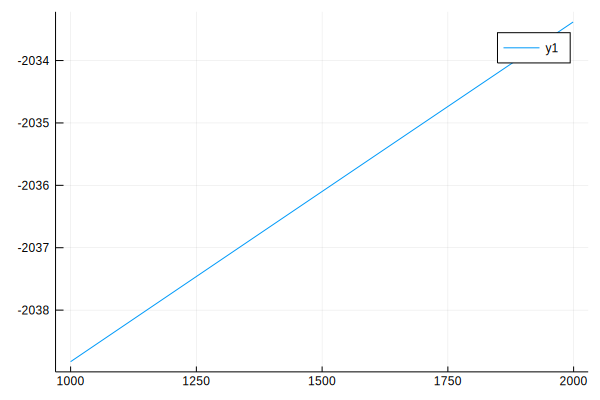

In [43]:
plot(1000:2000-1, k_a)

In [44]:
alpha = 1 .- k_s ./ k_a;

In [45]:
k_t = k_s ./ alpha;

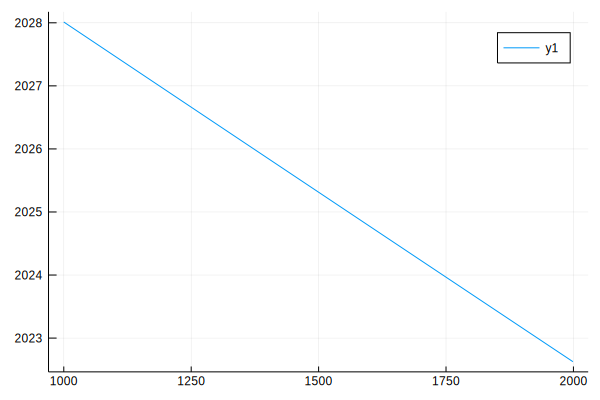

In [46]:
plot(1000:2000-1, k_t)

In [47]:
f_etac_params = meta_dict["product"]["dopplerCentroid"]["dcEstimateList"]["dcEstimate"][1]["dataDcPolynomial"][""]
f_etac_params = [parse(Float64, param) for param in split(f_etac_params)]
f_etac = f_etac_params[1] .+ f_etac_params[2].*(tau.-tau0) .+ f_etac_params[3].*(tau.-tau0).^2;

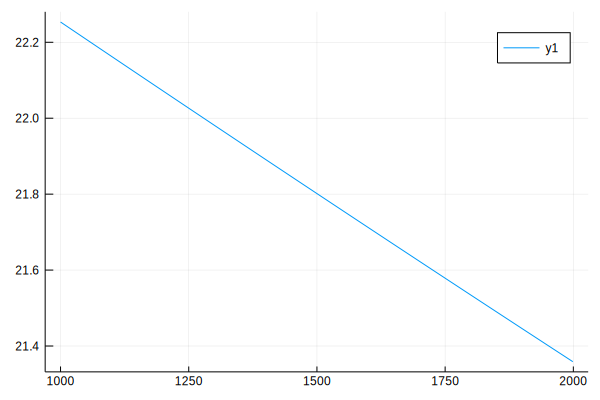

In [48]:
plot(1000:2000-1, f_etac)

In [ ]:
Geometry.original_view()

In [73]:
tau_mid = N_s/2 * Delta_tau_s

0.00019682886207143723

In [70]:
tau0-tau[end]

-3.1082331160116675e-5

In [75]:
eta_c = - f_etac ./ k_a;

In [76]:
temp = f_etac_params[1] + f_etac_params[2]*(tau_mid) + f_etac_params[3]*(tau_mid)^2/(k_a_params[1] + k_a_params[2]*(tau_mid) + k_a_params[3]*(tau_mid)^2);
eta_ref = eta_c .- (- temp);

In [81]:
eta = -N_l/2*Delta_t_s:Delta_t_s:N_l/2*Delta_t_s
length(eta)

1525

In [79]:
phi = pi .* k_t .* (eta - )

π = 3.1415926535897...

In [84]:
SlcUtil.original_view(data)

ArgumentError: ArgumentError: invalid index: lines_per_burst of type String

 ## SlcUtil library

In [86]:
views = [30:1470, 1000:2000];

In [87]:
data = Load.slc_data(path_img1,views);

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [88]:
test = SlcRaw(view, meta, data)

MethodError: MethodError: Cannot `convert` an object of type typeof(view) to an object of type Array{UnitRange,1}
Closest candidates are:
  convert(::Type{Array{T,N}}, !Matched::StaticArrays.SizedArray{S,T,N,M} where M) where {T, S, N} at /Users/eyu/.julia/packages/StaticArrays/3KEjZ/src/SizedArray.jl:62
  convert(::Type{Array{T,N}}, !Matched::AxisArrays.AxisArray{T,N,D,Ax} where Ax where D) where {T, N} at /Users/eyu/.julia/packages/AxisArrays/YXhV4/src/core.jl:295
  convert(::Type{T<:Array}, !Matched::AbstractArray) where T<:Array at array.jl:474
  ...

In [133]:
size(test)

(1441, 1001)

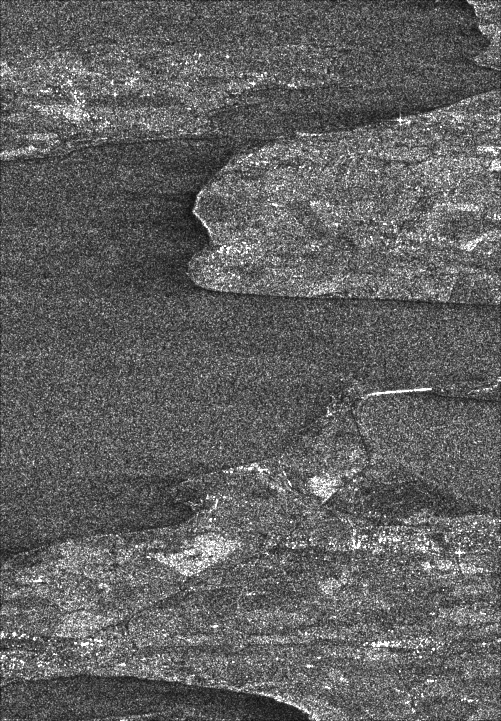

In [134]:
SlcUtil.show_img(test)